
# Advanced Data Science Capstone

## Correlation of air pollution and Prevalence of Heart failures in Germany  

## Exploratory research

### Data sources
As data sources I use the data sets oficially published by Geschäfts- und Koordinierungsstelle GovData, the search engine is available at https://www.govdata.de/web/guest/suchen.
The list of relevant data sets is following:

## Air quality:

Datastream **E1a** contains measured (Link to Datastream D) values of gas phase pollutants (e.g. Ozone, NO2, SO2, CO), particle pollutats (e.g. dust) and dust constituants (e.g. heavy metals, PAK in PM10, PM2.5, TSP) as well es total deposition (BULK), wet deposition and meteorologic data (e.g. temperature, wind, pressure)for every measurement location.

The data for years 2013 - 2018 is available. For the project start I will limit myself with 2017 data,
however the method and the model shoud be easily extendable for accommodation of the previous data.

Compressed dataset is available at https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2017.zip .

 - Air quality data (Datastream E1a) - Validated measurements from 2018 (Dataset).
   - Metadata in RDF format: https://www.govdata.de/ckan/dataset/cdadb71f-5571-4c95-af2a-d926efb4e3a0.rdf .
   - ATOM: Air quality data (INSPIRE Download/Atom Feed): https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Service_5e7bb800-c1db-4343-ac3e-a63204b0f6b7.atom.xml (N/A)
   - XML-Metadaa: Air quality data (Datastream E1a) - Validated measurements from 2018 (Dataset): http://www.geoportal.de/gds/xml.php?uuid=cdadb71f-5571-4c95-af2a-d926efb4e3a0
   
 - Positions of the air quality sensors (Datastream D): https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-d-beurteilungsmethoden-2017-datensatz.rdf.

## Health related information
Starting the search at the same site (https://www.govdata.de/web/guest/suchen) it was found, that the health indicator data with a fine (county) grid is not available at this site. 

At the https://de.statista.com/statistik/ the data of interest seems to be appearing, however a payed subscription is needed.

Finally, the https://www.versorgungsatlas.de/themen/alle-analysen-nach-datum-sortiert/ site contains county-averaged data on health indicators.

 - Health indicators
   - Self-evaluation of the health status, distribution of "bad" values by counties: https://www.versorgungsatlas.de/fileadmin/excel/data_id_31_kreis_1_j_1262217600.xlsx
   - Prevalence of Heart failures in the 2017 (used for the study): https://www.versorgungsatlas.de/fileadmin/excel/data_id_97_kreis11_2_j_1483228800.xlsx
   
## Auxiliary information

In order to connect the datasets from different origin, one need to have a geotagging in the same format.
The easiest way is to stick on county-based data, attribyte all air pollution sensors positions to corresponding counties. The data set containing the information on german towns and counties can be found at https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile.

### Initial Data Exploration
 - Load the data set and check it's structure, size and data quality (non-informative entries, data variability)
 - If the data set is big, make a sample subset
 - Make exploratory plots
 - May be make some e.g. hierarchical/k-means (?) clustering, finding patterns
 
### File naming conventions:

  *project_name*.**data_exp**.*technology.version.extension*  
  *project_name*.**etl**.*technology.version.extension*    
  *project_name*.**feature_eng**.*technology.version.extension*  
  *project_name*.**model_def**.*technology.version.extension*  
  *project_name*.**model_train**.*technology.version.extension*   
  *project_name*.**model_evaluate**.*technology.version.extension*   
  *project_name*.**model_deployment**.*technology.version.extension*   
    
Raw data files are placed to ./*project_name*.**rawData/**

### Loading all necessary libraries:

In [1]:
###import rdfpandas as pd
#!pip install rdflib
#!pip install networkx
#!pip install xlrd

import urllib.request
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import numpy as np

import re, collections
from io import StringIO
import os, fnmatch

import matplotlib.pyplot as plt

### Creating function for printing XML file structure
It will be useful, since almost all data at GovData.de is kept in *xml* format.

In [2]:
def PrintXML(XMLfileName):
    xml_root = (etree.parse(XMLfileName)).getroot()
    raw_tree = etree.ElementTree(xml_root)
    nice_tree = collections.OrderedDict()

    for tag in xml_root.iter():
        path = re.sub('\[[0-9]+\]', '', raw_tree.getpath(tag))
        if path not in nice_tree:
            nice_tree[path] = []
        if len(tag.keys()) > 0:
            nice_tree[path].extend(attrib for attrib in tag.keys() if attrib not in nice_tree[path])            
 
    for path, attribs in nice_tree.items():
        indent = int(path.count('/') - 1)
        print('{0}{1}: {2} [{3}]'.format('    ' * indent, indent, path.split('/')[-1], ', '.join(attribs) if len(attribs) > 0 else '-'))

### Downloading the data
The code chunk is commented out in order to prevent multiple download of data.

In [3]:
## Download and decompress the dataset itself:
#!mkdir Capstone.rawData
#!mkdir Capstone.rawData/AQD_DE_E1a_2017
#!ls -l Capstone.rawData/
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2017.zip", "Capstone.rawData/AQD_DE_E1a_2017.zip")
#!mv Capstone.rawData/AQD_DE_E1a_2017.zip Capstone.rawData/AQD_DE_E1a_2017/
#!unzip Capstone.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip
#!unzip Capstone.rawData/AQD_DE_E1a_2017/DISKO.zip -d Capstone.rawData/AQD_DE_E1a_2017/
#!unzip Capstone.rawData/AQD_DE_E1a_2017/KONTI.zip -d Capstone.rawData/AQD_DE_E1a_2017/
#!rm Capstone.rawData/AQD_DE_E1a_2017/DISKO.zip Capstone.rawData/AQD_DE_E1a_2017/KONTI.zip
#!mv ./E1a Capstone.rawData/AQD_DE_E1a_2018/
#!mv Capstone.rawData/AQD_DE_E1a_2018/E1a/* Capstone.rawData/AQD_DE_E1a_2018/
#!rm -rf Capstone.rawData/AQD_DE_E1a_2018/E1a
#!ls -la /home/spark/shared/

#Download the dataset Metadata xml
#urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=cdadb71f-5571-4c95-af2a-d926efb4e3a0", "Capstone.rawData/AQD_DE_E1a_2018/E1a2018_meta.xml")
#urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=c533b9a5-e518-4bf8-9a0a-1b829acd561d", "Capstone.rawData/AQD_DE_E1a_2017/E1a2017_meta.xml") 

#Download Sensor positions
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2017.zip", "Capstone.rawData/AQD_DE_D_2017.zip")
#!unzip Capstone.rawData/AQD_DE_D_2017.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_D_2017.zip

# Download Town-county dataset:
#urllib.request.urlretrieve("https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile",
#                           "Capstone.rawData/GV100AD3107.zip")
#!mkdir Capstone.rawData/GV100AD3107
#!unzip Capstone.rawData/GV100AD3107.zip -d Capstone.rawData/GV100AD3107/
#!rm Capstone.rawData/GV100AD3107.zip


#!ls -la Capstone.rawData/AQD_DE_E1a_2017/
#!pwd

### Metadata XML file
Now let's take a look at the downloaded *E1a2018_meta.xml* file.
First print it's structure

In [4]:
PrintXML("Capstone.rawData/AQD_DE_E1a_2018/E1a2018_meta.xml")

0: gmd:MD_Metadata [{http://www.w3.org/2001/XMLSchema-instance}schemaLocation]
    1: gmd:fileIdentifier [-]
        2: gco:CharacterString [-]
    1: gmd:language [-]
        2: * [codeList, codeListValue]
    1: gmd:characterSet [-]
        2: * [codeList, codeListValue]
    1: gmd:hierarchyLevel [-]
        2: * [codeList, codeListValue]
    1: gmd:hierarchyLevelName [-]
        2: gco:CharacterString [-]
    1: gmd:contact [-]
        2: gmd:CI_ResponsibleParty [-]
            3: gmd:individualName [-]
                4: gco:CharacterString [-]
            3: gmd:organisationName [-]
                4: gco:CharacterString [-]
            3: gmd:positionName [-]
                4: gco:CharacterString [-]
            3: gmd:contactInfo [-]
                4: gmd:CI_Contact [-]
                    5: gmd:phone [-]
                        6: gmd:CI_Telephone [-]
                            7: gmd:voice [-]
                                8: gco:CharacterString [-]
                     

... that bring us not so much information.
Let's try to visualize it's **rdf** version using *networkx* library:  

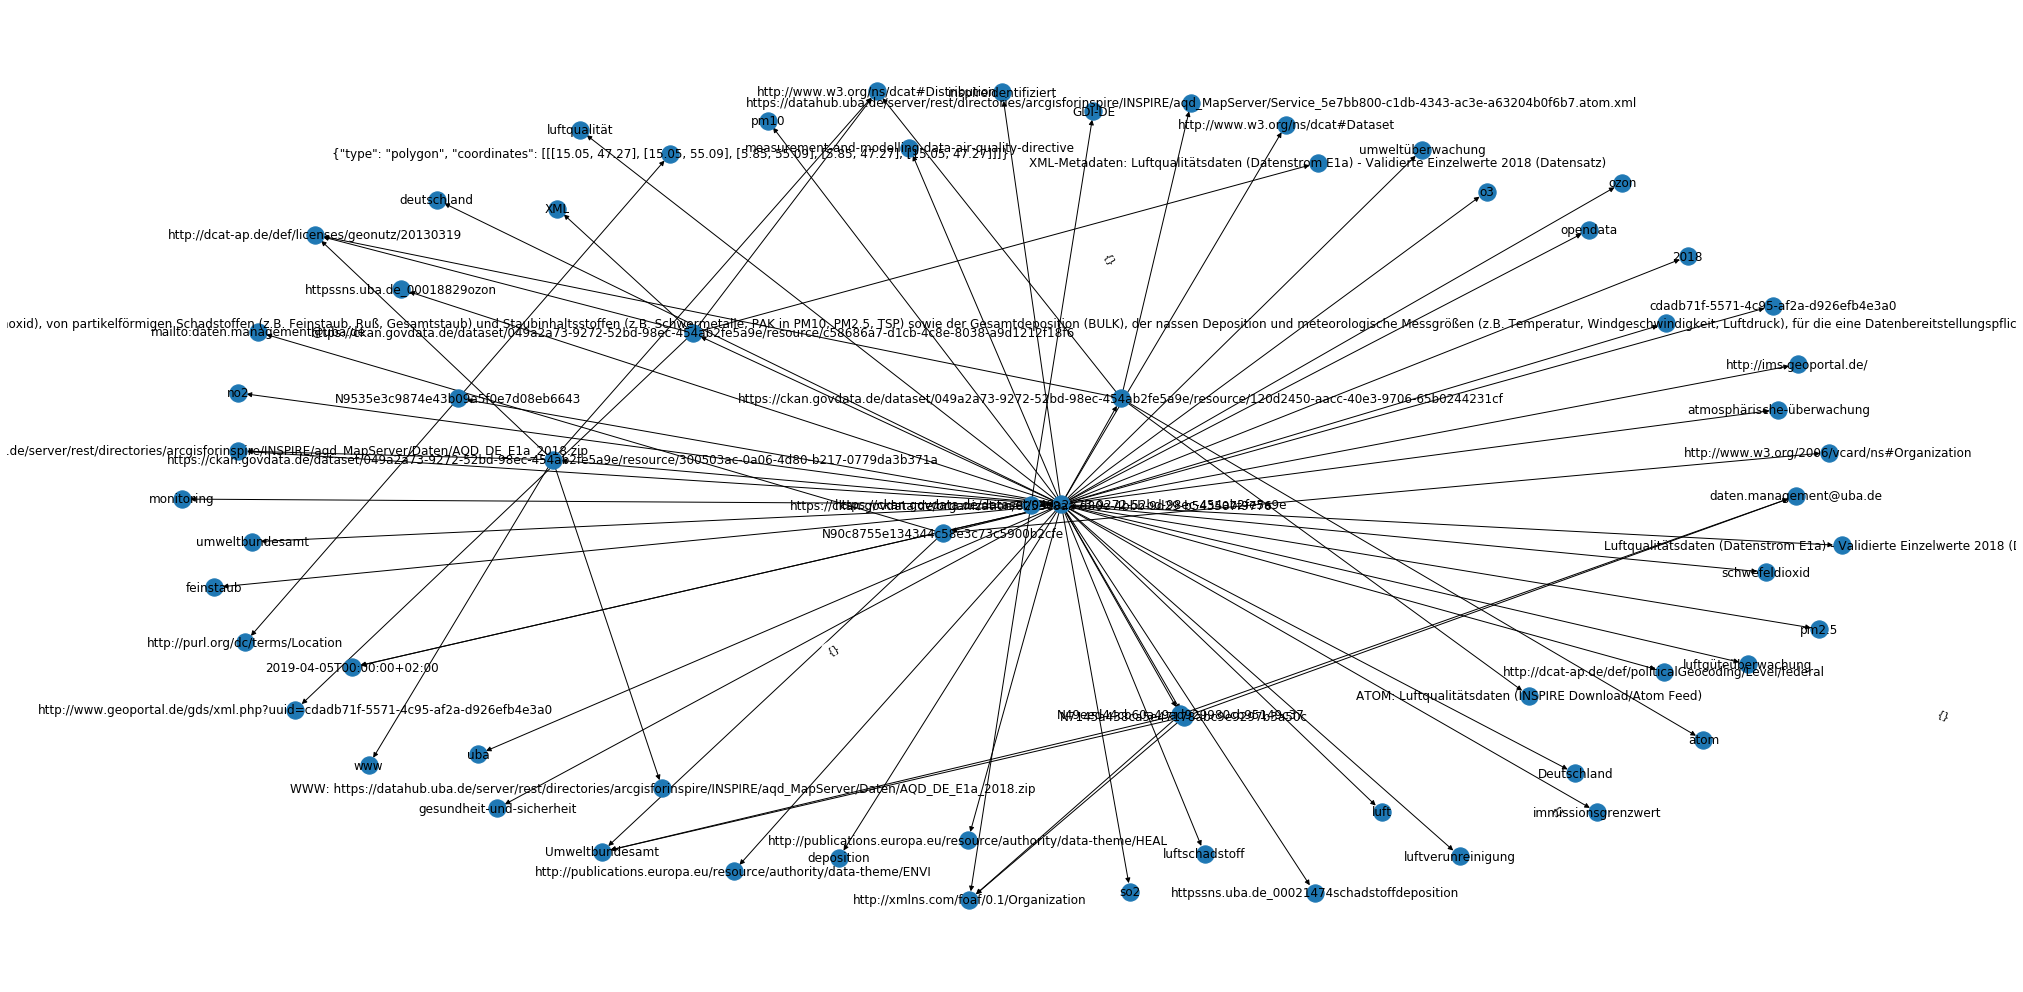

In [5]:

#### Metadata xml also contains info on the relations between datasets, models and organizations; It is not very informative.
import rdflib
from rdflib import Graph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx

    
### Metadata Graph shows relations between datasets, models and organizations; It is not very informative.
E1a2018_meta_graph = Graph()
E1a2018_meta_graph.parse("https://www.govdata.de/ckan/dataset/cdadb71f-5571-4c95-af2a-d926efb4e3a0.rdf")
E1a2018_meta_network = rdflib_to_networkx_multidigraph(E1a2018_meta_graph)
# Plot Networkx instance of RDF Graph
plt.figure(figsize=(36,18)) 
pos = nx.spring_layout(E1a2018_meta_network, scale=5)
edge_labels = nx.get_edge_attributes(E1a2018_meta_network, 'r')
nx.draw_networkx_edge_labels(E1a2018_meta_network, pos, labels=edge_labels)
nx.draw(E1a2018_meta_network, with_labels=True)
plt.show()

This also give us almost no information about the dataset.
Finaly, printing out persed *xml* file (it is not so big, just 37 kB, for code see commented chunk below) I found,
that it contains urls to data formats and standarts: http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode, https://registry.gdi-de.org/id/de.bund.uba.inspire.aqd/cdadb71f-5571-4c95-af2a-d926efb4e3a0, etc.

Also it contains description of the measurement details: *Datenstrom E1a umfasst gemessene (Link zu Datenstrom D) Einzelwerte von gasförmigen Schadstoffen (z. B. Ozon, Stickstoffdixoid, Schwefeldioxid, Kohlenmonoxid), von partikelförmigen Schadstoffen (z.B. Feinstaub, Ruß, Gesamtstaub) und Staubinhaltsstoffen (z.B. Schwermetalle, PAK in PM10, PM2.5, TSP) sowie der Gesamtdeposition (BULK), der nassen Deposition und meteorologische Messgrößen (z.B. Temperatur, Windgeschwindigkeit, Luftdruck), für die eine Datenbereitstellungspflicht besteht. Der Bericht umfasst zudem die Datenqualitätsziele (Messunsicherheit, Mindestzeiterfassung (time coverage) erfüllt ja/nein, Mindestdatenerfassung (data capture) erfüllt ja/nein) und Informationen zu Konzentrationswerten die natürlichen Quellen und der Ausbringung von Streusand und –salz zuzurechnen sind (Konzentrationswerte ohne etwaige Korrekturabzüge)*.

Since I will normalize the data anyway, the only important thing is that all the data sets contains the same units. However the units of measurements are also mentioned in the data files themselves, as it will be shown later, so these metadata files are out of use, at least for the moment.

In [6]:
#import xml.dom.minidom
#with open('Capstone.rawData/AQD_DE_E1a_2018/E1a2018_meta.xml', encoding='utf-8') as xmldata:
#    xml = xml.dom.minidom.parseString(xmldata.read())  # or xml.dom.minidom.parseString(xml_string)
#    xml_pretty_str = xml.toprettyxml()
#print(xml_pretty_str)

### Dataset files analysis
Let's take a look at the downloaded data set:

In [7]:
!ls -la Capstone.rawData/AQD_DE_E1a_2017/

total 2602840
drwxr-xr-x  224 gorelov  staff      7168 Jul  8 11:07 .
drwxr-xr-x    8 gorelov  staff       256 Jul 10 10:26 ..
-rw-r--r--@   1 gorelov  staff      6148 Jul  8 10:51 .DS_Store
-rw-r--r--    1 gorelov  staff   2751199 Sep 14  2018 DE_BB_2017_CO_hour.xml
-rw-r--r--    1 gorelov  staff  13326393 Sep 14  2018 DE_BB_2017_NO2_hour.xml
-rw-r--r--    1 gorelov  staff  13176095 Sep 14  2018 DE_BB_2017_NO_hour.xml
-rw-r--r--    1 gorelov  staff  13284052 Sep 14  2018 DE_BB_2017_NOx_hour.xml
-rw-r--r--@   1 gorelov  staff   8940897 Sep 14  2018 DE_BB_2017_O3_hour.xml
-rw-r--r--    1 gorelov  staff     30386 Sep 14  2018 DE_BB_2017_PM10_BaA_day.xml
-rw-r--r--    1 gorelov  staff     30376 Sep 14  2018 DE_BB_2017_PM10_BaP_day.xml
-rw-r--r--    1 gorelov  staff     30338 Sep 14  2018 DE_BB_2017_PM10_BbF_day.xml
-rw-r--r--    1 gorelov  staff     30337 Sep 14  2018 DE_BB_2017_PM10_BjF_day.xml
-rw-r--r--    1 gorelov  staff     30413 Sep 14  2018 DE_BB_2017_PM10_BkF_day.xml
-rw-r--r--  

It is clear, that filenames contain information on the file contents:
e.g. **DE_BB_2018_NOx_hour.xml**: **DE** for Germany, **BB** for Brandenburg region, **2018** for year of measurements, **NOx** for kind of pollutant (nitrogen oxides), **hour** for type of measurements.  

Now let's take a look at the *xml* file structure:

In [8]:

PrintXML("Capstone.rawData/AQD_DE_E1a_2017/DE_BB_2017_NOx_hour.xml")


0: gml:FeatureCollection [{http://www.w3.org/2001/XMLSchema-instance}schemaLocation, {http://www.opengis.net/gml/3.2}id]
    1: gml:featureMember [-]
        2: om:OM_Observation [{http://www.opengis.net/gml/3.2}id]
            3: om:phenomenonTime [-]
                4: gml:TimePeriod [{http://www.opengis.net/gml/3.2}id]
                    5: gml:beginPosition [-]
                    5: gml:endPosition [-]
            3: om:resultTime [-]
                4: gml:TimeInstant [{http://www.opengis.net/gml/3.2}id]
                    5: gml:timePosition [-]
            3: om:procedure [{http://www.w3.org/1999/xlink}href]
            3: om:parameter [-]
                4: om:NamedValue [-]
                    5: om:name [{http://www.w3.org/1999/xlink}href]
                    5: om:value [{http://www.w3.org/1999/xlink}href, {http://www.w3.org/2001/XMLSchema-instance}type]
            3: om:observedProperty [{http://www.w3.org/1999/xlink}href]
            3: om:featureOfInterest [{http://ww

Agan, a lot of urls describing standards, however the structure of file becomes clearer.
Let's check the first rank entries from the root:

In [9]:
xml_tree = etree.parse("Capstone.rawData/AQD_DE_E1a_2017/DE_BB_2017_NOx_hour.xml")
xml_root = xml_tree.getroot()
for child in xml_root:
    print(child.tag, child.attrib) 

{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.

It seems to be, that the file can contain measurements from 25 sensors at different locations (as it will be shown later, actual file contains only 24 sensors data, the first entry is used for auxiliary information). 
An *xml* file entry consist of three possible elements: **tag**, like key or variable name; **attrib**, like value of variable, and **text**, that acommodates everything between corresponding tags (up to video in *base64* encoding). 
For the further use I will collect all the **tag**s from the dataset file and store it to the *AllTags* list.


In [10]:
# pick all tags from the XML file
Etree = ET.parse("Capstone.rawData/AQD_DE_E1a_2017/DE_BB_2017_NOx_hour.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])
#varName = 'observedProperty'
#print("\n".join([s for s in AllTags if varName in s]))    

['{http://www.opengis.net/swe/2.0}Count', '{http://www.opengis.net/swe/2.0}value', '{http://www.opengis.net/swe/2.0}elementType', '{http://www.opengis.net/swe/2.0}DataRecord', '{http://www.opengis.net/swe/2.0}field', '{http://www.opengis.net/swe/2.0}Time', '{http://www.opengis.net/swe/2.0}uom', '{http://www.opengis.net/swe/2.0}field', '{http://www.opengis.net/swe/2.0}Time', '{http://www.opengis.net/swe/2.0}uom', '{http://www.opengis.net/swe/2.0}field', '{http://www.opengis.net/swe/2.0}Category']


## Exploring Dataset XML structure
First of all, let's write functions, that will fetch *xml* tags by contained keyword.
The ideas about keywords needed can be got from looking at *AllTags* list.
The function *FetchAllXMLsensor* parses the sensor ID from the corresponding *xml* **attr**
at the **value** tag.

In [11]:
def FetchXMLentryByWord(varName, NumToPrint):
    varFull = [s for s in AllTags if varName in s][NumToPrint]
    print(varFull)
    print([(varr.attrib, varr.text) for varr in Eroot.iter(varFull)][NumToPrint])
    print('\n')
def FetchAllXMLentriesByWord(varName):
    varFull = [s for s in AllTags if varName in s][0]
    print([(varr.attrib) for varr in Eroot.iter(varFull)])
    print('\n')
def FetchAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    print([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    print('\n')
def SelectAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    return([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    

Using the Fetch functions, one can show, that units of measurements in this *xml* file are **microgramm pro cubic meter**, the pollutant is of type 9 (according to the given url it is **NOX as NO2**)  and observation time os an **hour**. 

One can parse sensor IDs in form of **DEBB007_NOx_dataGroup1**,
where **DE** stands for Germany, **BB** for Brandenburg region, **007** is the sensor number (this information will be used later for geotagging), **NOx** for kind of pollutant (nitrogen oxides), and the **dataGroup1** is some common index.

The pollutant concentration data is stored in **text** fields of the entries with **value** tag; the data is stored in the *csv* format, end line symbol is "@@":

In [12]:
FetchXMLentryByWord('Quantity', 0)

FetchXMLentryByWord('uom', 2)    
FetchXMLentryByWord('observedProperty', 0)    

FetchAllXMLsensorID()

FetchXMLentryByWord('TextEncoding', 0)
ColNamesExp=SelectAllXMLsensorID()

{http://www.opengis.net/swe/2.0}Quantity
({'definition': 'http://dd.eionet.europa.eu/vocabulary/aq/primaryObservation/hour'}, '\n                ')


{http://www.opengis.net/swe/2.0}uom
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/uom/concentration/ug.m-3'}, None)


{http://www.opengis.net/om/2.0}observedProperty
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/aq/pollutant/9'}, None)


['DEBB007_NOx_dataGroup1', 'DEBB021_NOx_dataGroup1', 'DEBB029_NOx_dataGroup1', 'DEBB032_NOx_dataGroup1', 'DEBB044_NOx_dataGroup1', 'DEBB045_NOx_dataGroup1', 'DEBB048_NOx_dataGroup1', 'DEBB049_NOx_dataGroup1', 'DEBB053_NOx_dataGroup1', 'DEBB054_NOx_dataGroup1', 'DEBB055_NOx_dataGroup1', 'DEBB060_NOx_dataGroup1', 'DEBB063_NOx_dataGroup1', 'DEBB064_NOx_dataGroup1', 'DEBB065_NOx_dataGroup1', 'DEBB066_NOx_dataGroup1', 'DEBB067_NOx_dataGroup1', 'DEBB068_NOx_dataGroup1', 'DEBB073_NOx_dataGroup1', 'DEBB075_NOx_dataGroup1', 'DEBB083_NOx_dataGroup1',

## Reading Pollutant concentration Measurements to DataFrame
For exploratory analysis the data should be loaded to some toolbox, in this case *Pandas* in form of *Pandas Dataframe*. As it was shown before, one have to parse **text** fields of the entries with **value** tag as a normal *csv* file: 

In [13]:
varFull = [s for s in AllTags if 'values' in s][0]

dff=[]
for varr in Eroot.iter(varFull):
    dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))

In [14]:
[dff[s].shape for s in range(0,len(dff))]

[(8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5)]

In [15]:
dff[22].tail(5)

,0,1,2,3,4
8755,2017-12-31T19:00:00+01:00,2017-12-31T20:00:00+01:00,1,1,3.82
8756,2017-12-31T20:00:00+01:00,2017-12-31T21:00:00+01:00,1,1,3.82
8757,2017-12-31T21:00:00+01:00,2017-12-31T22:00:00+01:00,1,1,5.07
8758,2017-12-31T22:00:00+01:00,2017-12-31T23:00:00+01:00,1,1,3.82
8759,2017-12-31T23:00:00+01:00,2017-12-31T24:00:00+01:00,1,1,3.82


From the chunks above one can see that in the current **DE_BB_2018_NOx_hour.xml** file there is measurement data for 24 sensors, each containing **8760** values - one measurement for each hour of the year. At least in the current file there are no NA values:

In [16]:
[dff[s].isnull().sum() for s in range(0,len(dff))]

[0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3  

<Figure size 432x288 with 0 Axes>

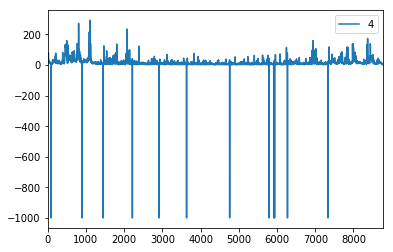

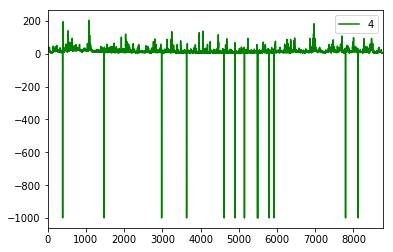

In [17]:
plt.figure()
((dff[0])[[4]]).plot()
((dff[22])[[4]]).plot(style='g')


From the figures above it is clear that the data contains also failed measurements, encoded as negative values (pollutant concentration cannot be negative). It meams that *imputting* strategy should be developed in order to treat the problem. At the moment these negative values will be replaced with zeroes, it will cause no problem for initial exploratory analysis:

In [18]:
dffAll=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
dffAll.columns=ColNamesExp
dffAll=dffAll.clip(lower=0)
dffAll.head(5)

,DEBB007_NOx_dataGroup1,DEBB021_NOx_dataGroup1,DEBB029_NOx_dataGroup1,DEBB032_NOx_dataGroup1,DEBB044_NOx_dataGroup1,DEBB045_NOx_dataGroup1,DEBB048_NOx_dataGroup1,DEBB049_NOx_dataGroup1,DEBB053_NOx_dataGroup1,DEBB054_NOx_dataGroup1,...,DEBB065_NOx_dataGroup1,DEBB066_NOx_dataGroup1,DEBB067_NOx_dataGroup1,DEBB068_NOx_dataGroup1,DEBB073_NOx_dataGroup1,DEBB075_NOx_dataGroup1,DEBB083_NOx_dataGroup1,DEBB086_NOx_dataGroup1,DEBB092_NOx_dataGroup1,DEBB099_NOx_dataGroup1
0,72.39,25.92,27.44,30.68,92.07,235.00,31.12,60.04,15.63,116.14,...,10.01,16.77,29.20,103.85,327.48,19.91,79.48,44.47,45.47,45.49
1,45.29,15.77,14.03,13.50,66.57,47.65,16.04,20.46,12.89,84.09,...,9.86,19.93,14.30,66.04,70.65,15.58,49.26,28.85,15.49,18.65
2,34.04,13.66,15.87,14.41,46.80,34.38,15.02,22.81,17.15,88.27,...,11.77,19.40,14.29,50.49,45.04,13.55,44.05,37.64,16.54,18.59
3,30.59,12.83,15.87,16.90,55.84,32.92,13.77,19.32,18.81,93.26,...,13.14,18.64,12.02,32.77,49.27,12.09,33.64,47.26,18.94,17.33
4,30.31,15.04,21.78,17.56,48.73,34.91,13.70,15.36,15.59,58.26,...,12.60,18.71,11.71,27.36,55.35,11.57,30.97,45.56,20.81,17.01


Now we can plot selected **DE_BB_2018_NOx_hour.xml** file as a timeseries: 

<Figure size 2592x1296 with 0 Axes>

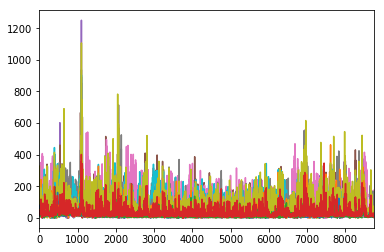

In [19]:
plt.figure(figsize=(36,18))
dffAll.plot(legend=None)

However for such a long-term effects as a public health impact, some detived quantities, like *number of days in year with too high pollutant concentration*, or some other integral quantities will be used. At the current stage a summary over the year w.r.t. the sensors can be done:

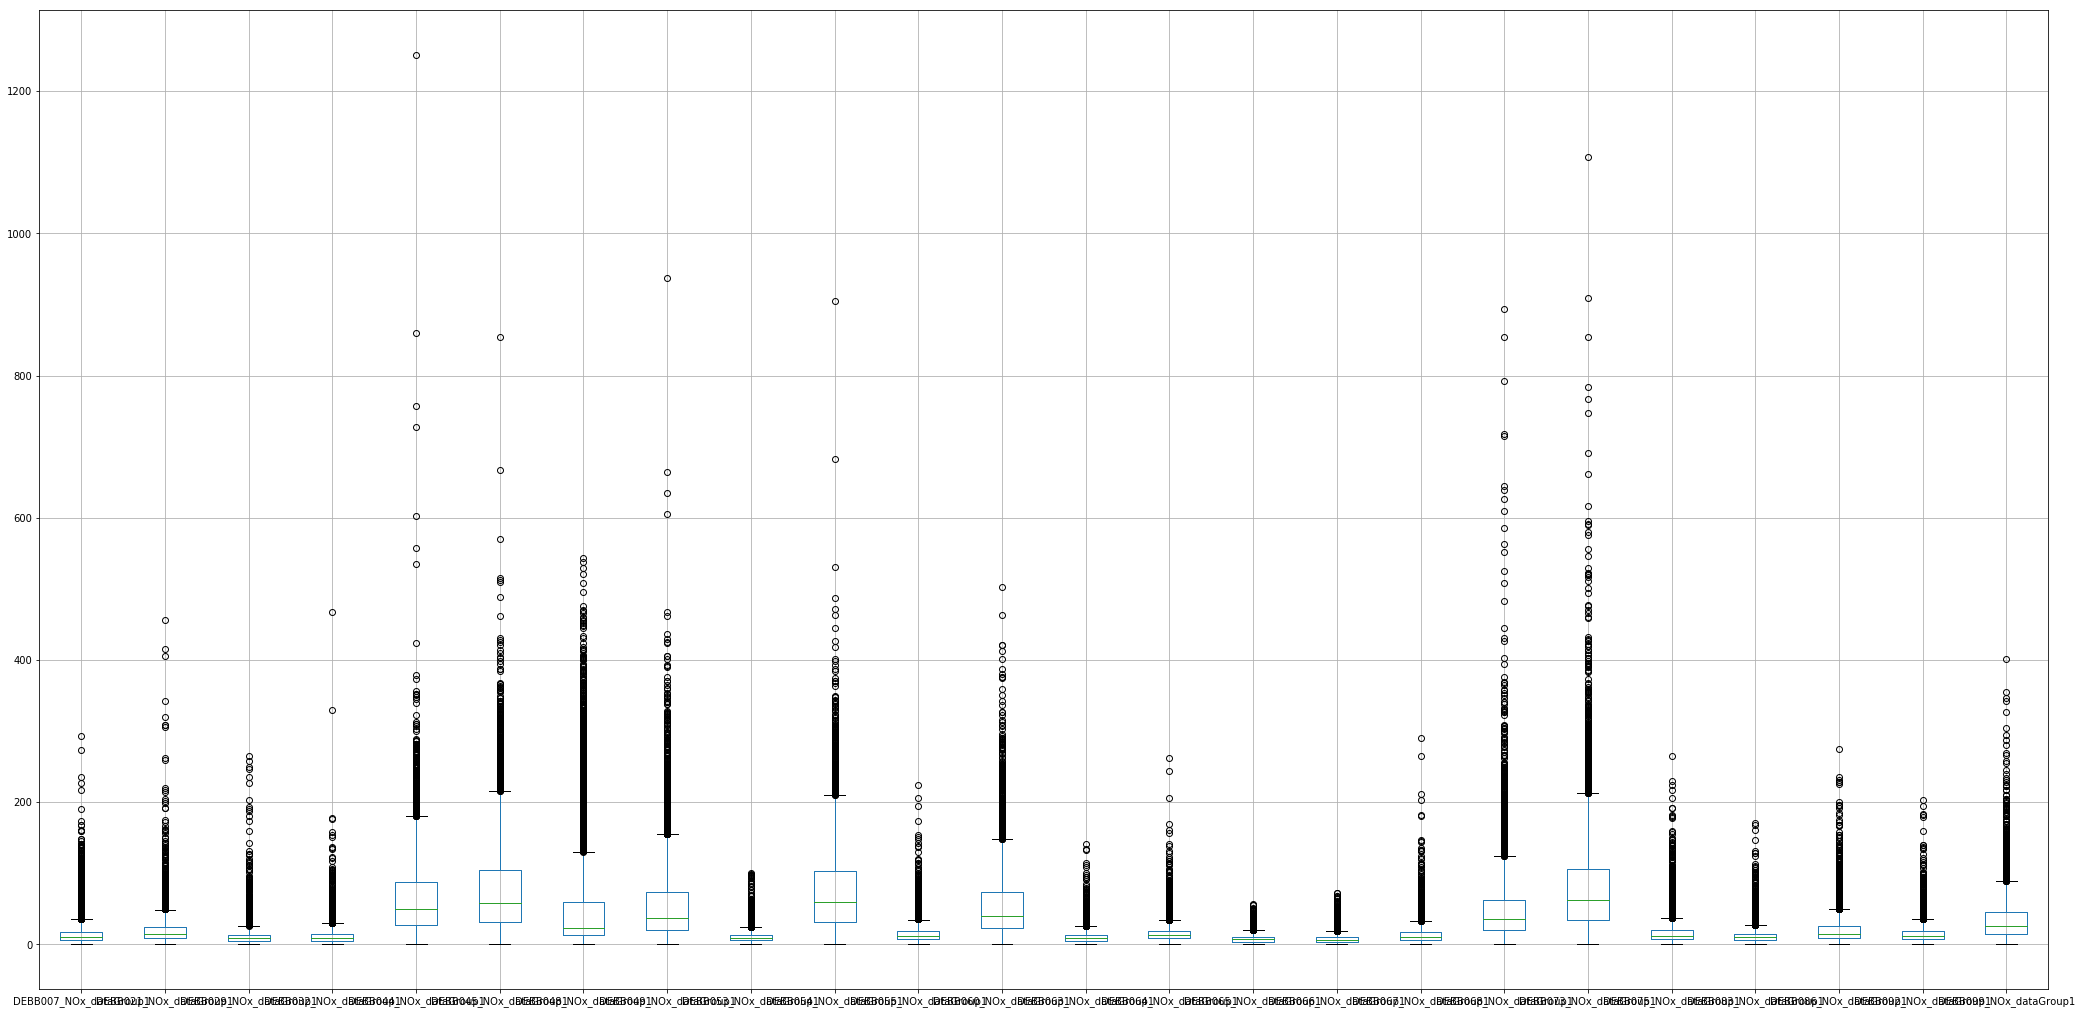

In [20]:
plt.figure(figsize=(36,18))
dffAll.boxplot()

On the figure above one can see that different sensors demonstrate significantly different statistics, so the data variativity should be enough to be used in the project. Also a quick check of the sanity of the whole pollutant dataset could be done by plotting all the files in the manner showed above: 

156


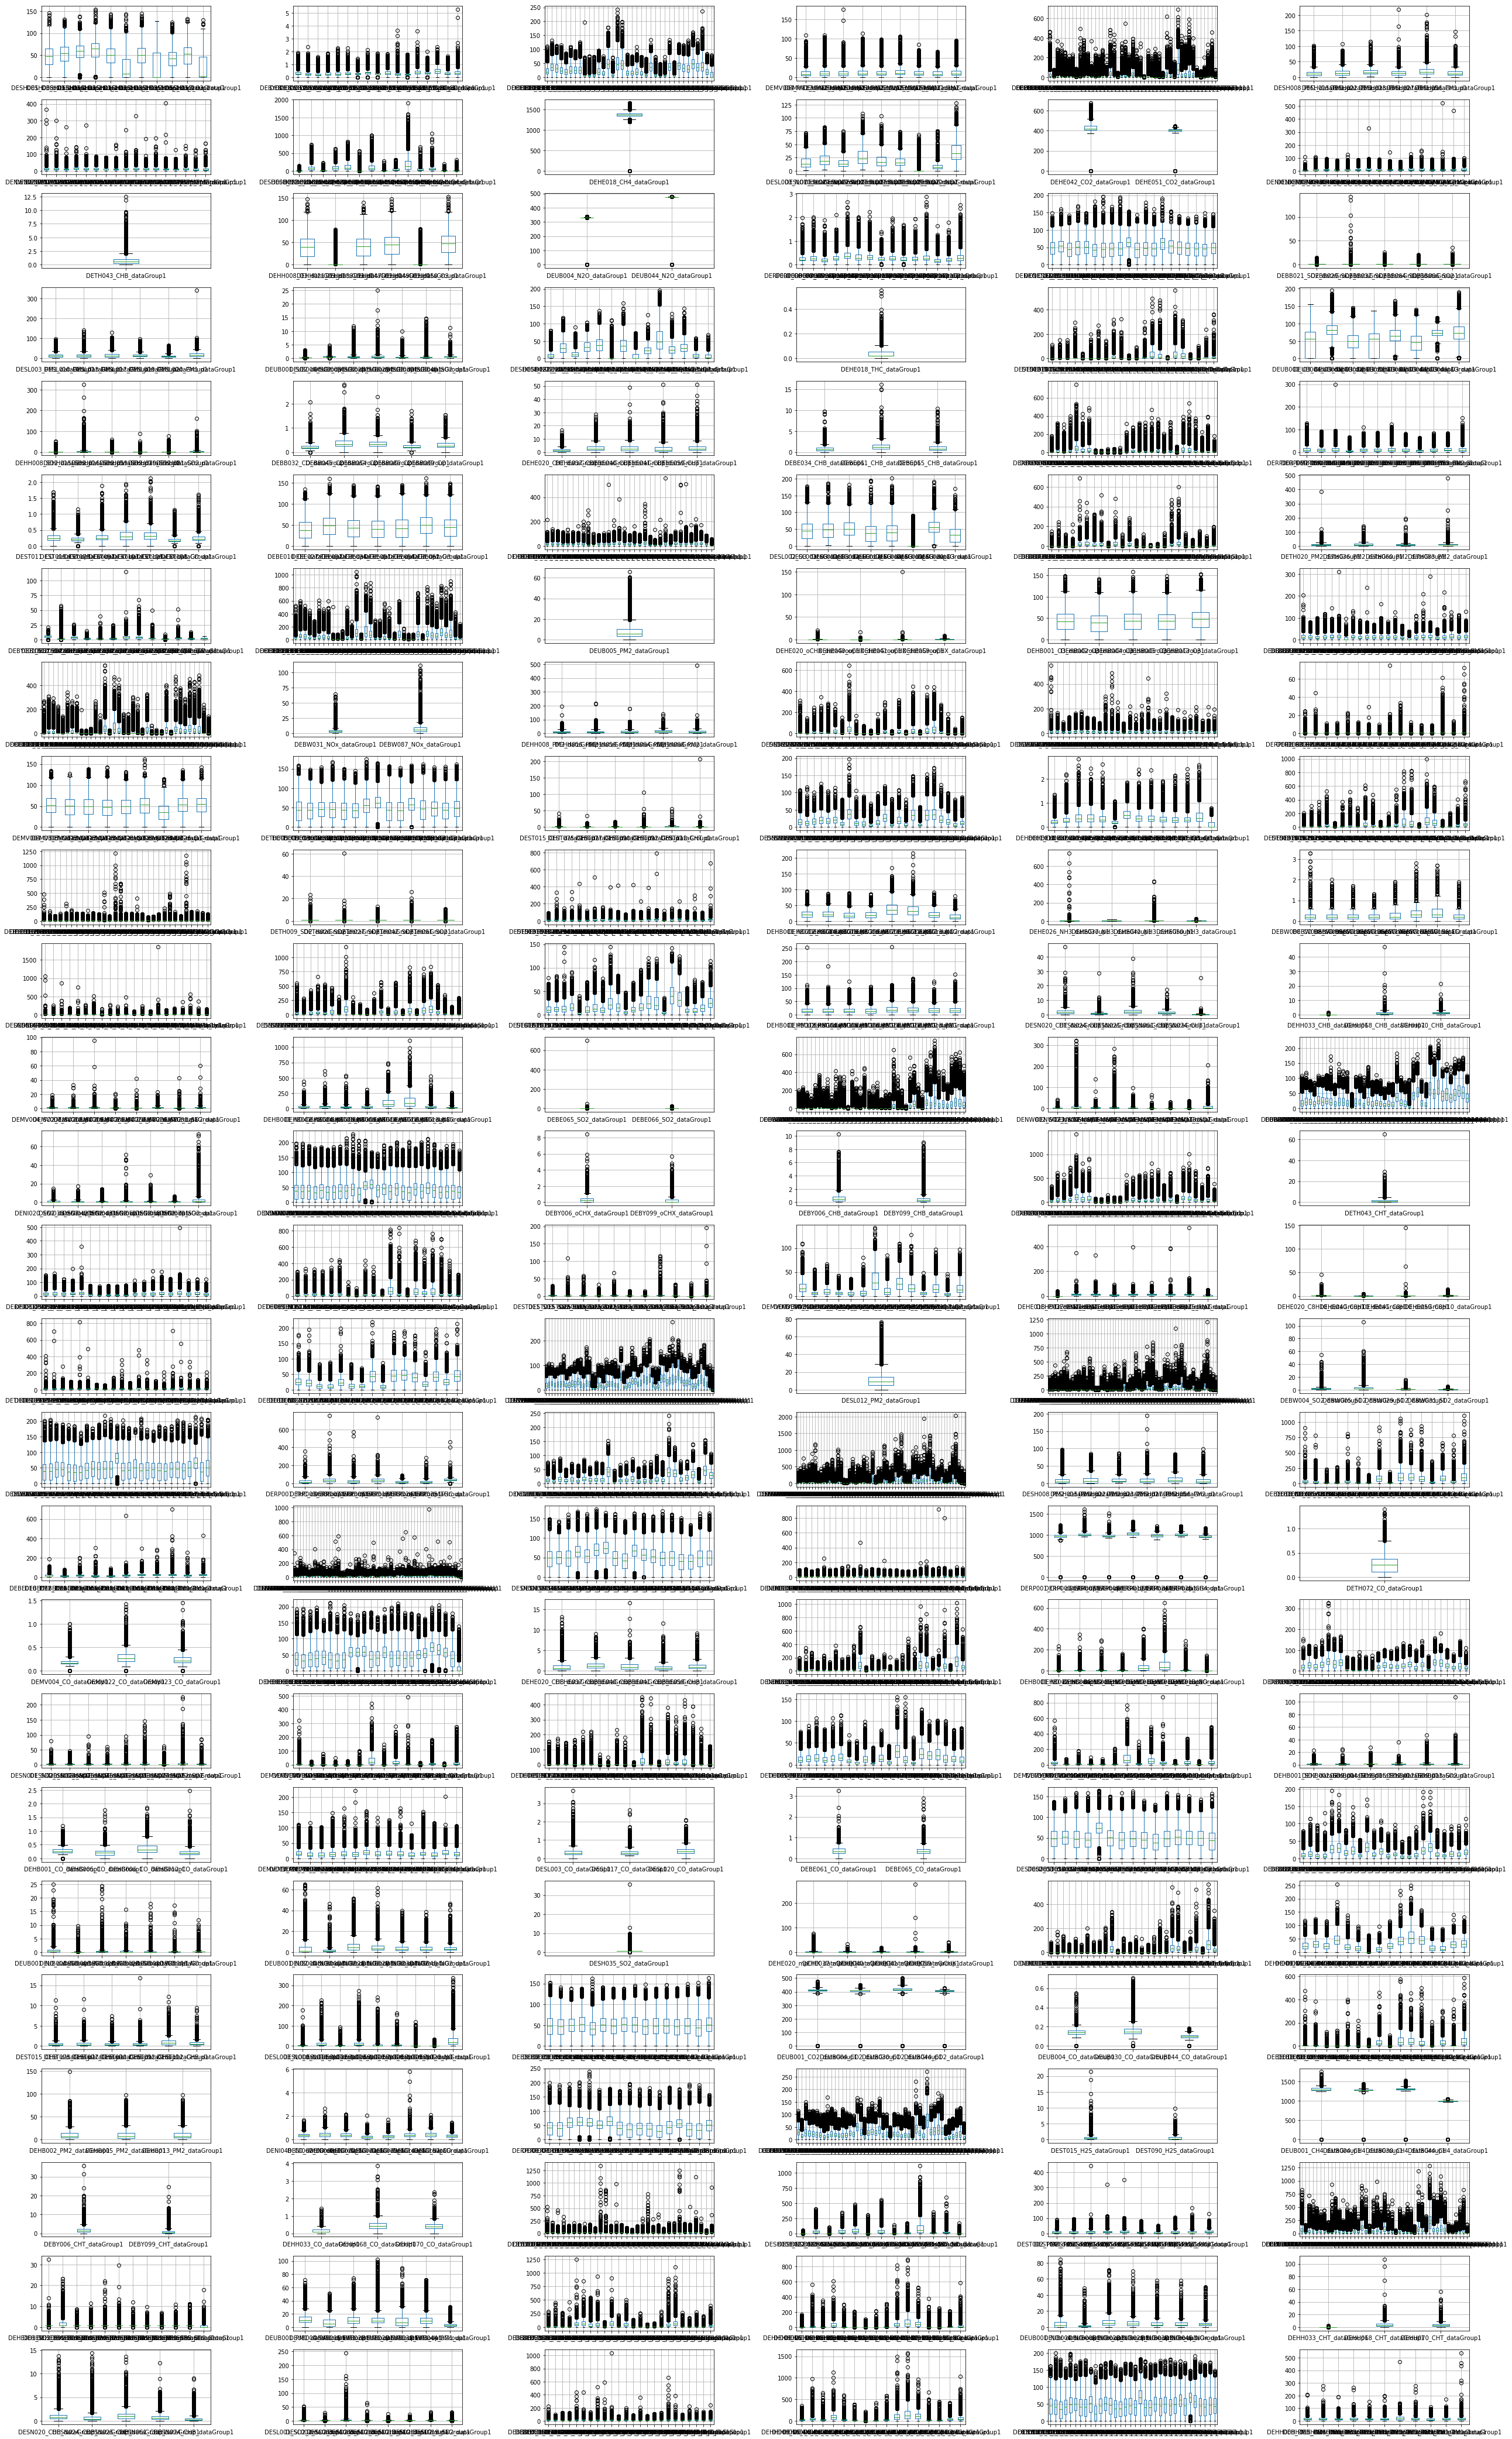

In [21]:
#!ls Capstone.rawData/AQD_DE_E1a_2017/*hour*
FilesHour=[]

for file in os.listdir('Capstone.rawData/AQD_DE_E1a_2017/'):
    if fnmatch.fnmatch(file, '*hour*'):
        FilesHour.append(file)
print(len(FilesHour))

#FilesHour=FilesHour[0:12]        

fig = plt.figure(figsize=(36,58))
NfigRows=26
NfigCols=6


for file in FilesHour:
    Etree = ET.parse('Capstone.rawData/AQD_DE_E1a_2017/'+file)
    Eroot = Etree.getroot()
    Eroot.tag
    Eroot.attrib
    AllTags = [elem.tag for elem in Eroot.iter()]
    
    ColNamesExp=SelectAllXMLsensorID()
    
    varFull = [s for s in AllTags if 'values' in s][0]
    dff=[]
    for varr in Eroot.iter(varFull):
        dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))
    
    dffAll=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
    dffAll.columns=ColNamesExp
    dffAll=dffAll.clip(lower=0)
    
    ax = fig.add_subplot(NfigRows,NfigCols,(FilesHour.index(file)+1))
    ax = (dffAll.boxplot(return_type='both'))
    
plt.tight_layout()
plt.show()

## Sensor position data
Let's examine the xml file with sensor position data. The sensor IDs are encoded by *text* of **natlStationCode** and **EUStationCode** tags, and the name of municipality is in *text* of **municipality** tag. More detailed location information, like coordinates (**pos**) and elevation (**altitude**) is available, however it is irrelevant for the present study.

In [22]:
# pick all tags from the XML file
Etree = etree.parse("Capstone.rawData/AQD_DE_D_2017/DE_D_allInOne_metaMeasurements_2017.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])
#varName = 'observedProperty'
#print("\n".join([s for s in AllTags if varName in s])) 

['{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}municipality', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}EUStationCode', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}stationInfo', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}areaClassification', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}altitude', '{http://www.opengis.net/gml/3.2}featureMember', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}AQD_SamplingPoint', '{http://inspire.ec.europa.eu/schemas/ef/3.0}inspireId', '{http://inspire.ec.europa.eu/schemas/base/3.3}Identifier', '{http://inspire.ec.europa.eu/schemas/base/3.3}localId', '{http://inspire.ec.europa.eu/schemas/base/3.3}namespace', '{http://inspire.ec.europa.eu/schemas/base/3.3}versionId']


In [23]:
#len(AllTags)
varMUN = [s for s in AllTags if 'municipality' in s][0]
varID  = [s for s in AllTags if 'EUStationCode' in s][0]
varFeatMem = [s for s in AllTags if 'featureMember' in s][0]


IDs=[]
MUNs=[]

for varr in Eroot.iter(varFeatMem):
    for child in varr.iter(varMUN):
        MUNs.append(child.text)
        for child2 in varr.iter(varID):
            IDs.append(child2.text)
SensorLocation=pd.DataFrame({'SensorID': IDs, 'SensorTown': MUNs})
SensorLocation.tail(5)

,SensorID,SensorTown
803,DEUB005,Lüder
804,DEUB028,Zingst
805,DEUB029,Suhl
806,DEUB030,Stechlin
807,DEUB044,Garmisch-Partenkirchen


### Town-County table
However available disease statistics is collected on the county base, not a town-based.
So, the next step will be download of town-county database, and adding a county column(s) to the **SensorLocation** dataset:

In [24]:
columns = [(10, 15), (22, 71), (72, 121)]
dfCT = pd.read_fwf("Capstone.rawData/GV100AD3107/GV100AD_310719.ASC", 
                     colspecs=columns, names=['countyid','town','county'],
                     encoding="iso8859_1")
dfCT=dfCT.fillna(method='ffill')

dfCT['town'] = dfCT['town'].str.split(",").str[0]
dfCT.tail(5)

,countyid,town,county
16116,16077,Starkenberg,Schmölln/Thür.
16117,16077,Thonhausen,Schmölln/Thür.
16118,16077,Treben,Schmölln/Thür.
16119,16077,Vollmershain,Schmölln/Thür.
16120,16077,Windischleuba,Schmölln/Thür.


## Prevalence of Heart failures
The dataset can be downloaded at http://www.geoportal.de/gds/xml.php?uuid=DC9CAF92-8868-4E42-A718-C0EA9A99A5F0 in xlsx format:

xls sheet names:  ['Hintergrundinformationen', 'Daten']
             Region  Regions-ID  KV           Kreistyp  Wert  Bundeswert
0            Lk.Hof        9475  BY  Ländliches Umland  6.43        3.11
1  Mansfeld-Südharz       15087  ST    Ländlicher Raum  6.37        3.11
2               Hof        9464  BY  Ländliches Umland  6.36        3.11
Length of the dataset:  402


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1247fa470>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

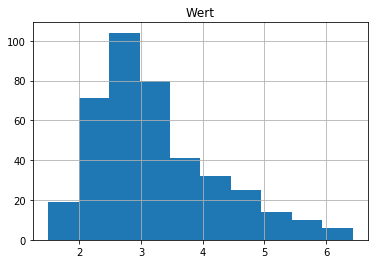

In [25]:
#!mkdir Capstone.rawData/Heart_2017
#urllib.request.urlretrieve("https://www.versorgungsatlas.de/fileadmin/excel/data_id_97_kreis11_2_j_1483228800.xlsx", "Capstone.rawData/Heart_2017/data_id_97_kreis11_2_j_1483228800.xlsx")

xlsx_file = pd.ExcelFile("Capstone.rawData/Heart_2017/data_id_97_kreis11_2_j_1483228800.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfHeart = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfHeart.head(3))
print("Length of the dataset: ",len(dfHeart))
plt.figure()
dfHeart.hist(column='Wert')

One can see, that the dataset is of length 402, and it contains name and ID of county (**Region**,**Regions-ID**), state ID (**KV**), type of county (**Kreistyp**), normalized value of hearth failures prevalence (**Wert**), and the prevalence average (**Bundeswert**). The histogram of the normalized value of hearth failures prevalence is shown above. The data seems to have enough variability to be used in the study.

It also looks like, that the disease prevalence datasse has been averaged w.r.t. short (5-digit) county id, that can be same for different counties. The example is shown below; please note, that all locations are located in South Harz mountains. 

In [26]:
dfHeart.loc[dfHeart['Regions-ID']==15087]

,Region,Regions-ID,KV,Kreistyp,Wert,Bundeswert
1,Mansfeld-Südharz,15087,ST,Ländlicher Raum,6.37,3.11


In [27]:
dfCT.loc[dfCT['countyid']==15087]

,countyid,town,county
15081,15087,Mansfeld-Südharz,Sangerhausen
15082,15087,Allstedt,Sangerhausen
15083,15087,Arnstein,Sangerhausen
15084,15087,Eisleben,Sangerhausen
15085,15087,Gerbstedt,Sangerhausen
15086,15087,Hettstedt,Sangerhausen
15087,15087,Mansfeld,Sangerhausen
15088,15087,Sangerhausen,Sangerhausen
15089,15087,Seegebiet Mansfelder Land,Sangerhausen
15090,15087,Südharz,Sangerhausen
